# Plot Time

In [1]:
import xarray as xr
import ODLintake
from xrsignal import xrsignal
from scipy import signal
import pandas as pd
import numpy as np
from dask.distributed import Client
from matplotlib import pyplot as plt

In [2]:
client = Client()
client

/home/jhrag/anaconda3/envs/ooi_dev/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41639 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41639/status,
Dashboard: http://127.0.0.1:41639/status,Workers: 12
Total threads: 120,Total memory: 448.74 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38413,Workers: 12
Dashboard: http://127.0.0.1:41639/status,Total threads: 120
Started: Just now,Total memory: 448.74 GiB
Comm: tcp://127.0.0.1:38119,Total threads: 10
Dashboard: http://127.0.0.1:38979/status,Memory: 37.40 GiB
Nanny: tcp://127.0.0.1:44839,


In [3]:
ds,geo = ODLintake.open_ooi_DAS_SouthTx_RawData()

In [4]:
time_coord = pd.to_datetime(ds['RawDataTime'], unit='us')

In [5]:
ds = ds.assign_coords({'time':time_coord})

In [6]:
time_coord

DatetimeIndex(['2021-11-01 23:11:14.834000', '2021-11-01 23:11:14.839000',
               '2021-11-01 23:11:14.844000', '2021-11-01 23:11:14.849000',
               '2021-11-01 23:11:14.854000', '2021-11-01 23:11:14.859000',
               '2021-11-01 23:11:14.864000', '2021-11-01 23:11:14.869000',
               '2021-11-01 23:11:14.874000', '2021-11-01 23:11:14.879000',
               ...
               '2021-11-04 05:35:14.784000', '2021-11-04 05:35:14.789000',
               '2021-11-04 05:35:14.794000', '2021-11-04 05:35:14.799000',
               '2021-11-04 05:35:14.804000', '2021-11-04 05:35:14.809000',
               '2021-11-04 05:35:14.814000', '2021-11-04 05:35:14.819000',
               '2021-11-04 05:35:14.824000', '2021-11-04 05:35:14.829000'],
              dtype='datetime64[ns]', length=39168000, freq=None)

In [10]:
start_time = pd.Timestamp('2021-11-02 T17:00:00')

start_idx = np.argmin(np.abs(start_time-time_coord))
end_idx = start_idx + 3600*2*200

In [13]:
ds_slice = ds.isel({'distance':slice(0,47500,20), 'time':slice(start_idx, end_idx)})['RawData']

b,a = signal.butter(4, [0.15, 0.27], btype='bandpass')
ds_filt = xrsignal.filtfilt(ds_slice, dim='time', b=b, a=a)
ds_abs = np.abs(ds_filt)

In [15]:
ds_c = xrsignal.hilbert_mag(ds_filt, dim='time')

In [18]:
ds_c

<xarray.DataArray 'RawData' (distance: 2322, time: 1440000)>
dask.array<<this-array>-__hilbert_chunk, shape=(2322, 1440000), dtype=int32, chunksize=(150, 3000), chunktype=numpy.ndarray>
Coordinates:
  * distance  (distance) float64 1.923 1.964 2.005 2.046 ... 96.63 96.67 96.71
  * time      (time) datetime64[ns] 2021-11-02T16:59:59.999000 ... 2021-11-02...

In [21]:
ds_downsamp = ds_c.isel({'time':slice(0, 1440000,20*60)})

Text(0.5, 1.0, '2021-11-02 16:59:59.999000')

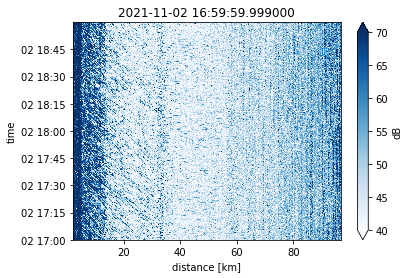

In [23]:
fig = plt.figure(figsize=(6,4))
ax = plt.gca()

(20*np.log10(ds_downsamp)).plot(x='distance',cmap='Blues', cbar_kwargs={'label':'dB'}, vmax=70, vmin=40, ax=ax)
_=plt.xlabel('distance [km]')
plt.title(time_coord[start_idx])

fig.savefig('figures/